In [1]:
import os
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import binned_statistic_2d
from scipy.stats import binned_statistic

In [2]:
import time
print(' Last revision ', time.asctime())
frames = []

for ifile in range(0, 8000): # Bucle para leer cada archivo individualmente 
    
    file = f'/Users/pablo/OneDrive - Universidade de Santiago de Compostela/Máster/TFM/dorothea/dorothea_{ifile}_kr83m.h5'

    if os.path.exists(file): # En caso de que el path del archivo exista, lo abre como DataFrame 
        
        if ifile%2==0: 
            
            #print(file)
            
            dst = pd.DataFrame(tb.open_file(file).root.DST.Events[:]) 

            frames.append(dst) # Guarda cada uno de los DataFrames en una lista
            
kdst = pd.concat(frames, ignore_index=True) # Hace un nuevo DataFrame juntando los individuales

kdst

 Last revision  Sun Nov 10 21:27:49 2024


,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,1600,1.601953e+09,0,0,1,1,200.0,7.0,19.0,10000.0,...,9,669.487854,562.369751,3.578721,-459.760008,-55.820768,463.136290,-3.020771,11.071444,10.575179
1,1602,1.602744e+09,0,0,1,1,125.0,5.0,15.0,10000.0,...,7,548.483154,460.725830,3.178156,-453.294198,-161.574950,481.229773,-2.799187,9.536605,10.081681
2,1604,1.605633e+09,0,0,1,1,250.0,3.0,14.0,10000.0,...,8,151.499710,127.259750,1.900903,443.049486,-14.897329,443.299873,-0.033612,9.465026,10.122552
3,1606,1.607813e+09,0,0,1,1,175.0,6.0,17.0,10000.0,...,8,516.493958,433.854889,3.219601,409.438144,-247.895722,478.635439,-0.544420,10.356321,10.591151
4,1608,1.608176e+09,0,0,1,1,175.0,4.0,15.0,10000.0,...,8,363.481140,305.324158,2.673991,-36.718107,-461.022901,462.482794,-1.650273,9.796269,10.497626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490087,6399190,6.399191e+12,0,0,1,1,250.0,5.0,21.0,10050.0,...,9,962.429321,808.440552,4.166302,-22.263757,224.603664,225.704410,1.669598,11.410413,11.547462
1490088,6399192,6.399192e+12,0,0,1,1,200.0,8.0,22.0,10000.0,...,9,1404.501953,1179.781616,4.982812,240.522545,-164.642069,291.475738,-0.600260,11.732220,10.877596
1490089,6399194,6.399195e+12,0,0,1,1,200.0,4.0,12.0,10050.0,...,7,435.438019,365.767914,2.907131,206.605181,-53.940802,213.530585,-0.255381,9.354601,10.132411
1490090,6399196,6.399196e+12,0,0,1,1,125.0,3.0,9.0,10000.0,...,6,315.484100,265.006622,2.488038,65.532921,-44.267010,79.083069,-0.594088,8.805151,8.863330


In [3]:
#for i in range(len(kdst['S2w'])):
 #   if kdst['S2w'][i]<0:
  #      print(i)

## PROFILE DE LOS DATOS

Aquí se estudia como es la tendencia de los datos que tenían una más alta correlación entre sí

In [4]:
n_bins = 50

s2w = kdst['S2w']
s2h = kdst['S2h']
s2e = kdst['S2e']
s2q = kdst['S2q']
s1w = kdst['S1w']
s1h = kdst['S1h']
s1e = kdst['S1e']

DT = kdst['DT']

Primero estudio la señal S2 respecto el DT

In [5]:
s2w = np.array([s for s, d in zip(s2w, DT) if d > 10])
DT=np.array([i for i in DT if i> 10])

# Calcular la media y desviación estándar de DT en bins de s2w
mean_s2w, bin_edges, _ = binned_statistic(DT, s2w, statistic='mean', bins=n_bins)
std_s2w, _, _ = binned_statistic(DT, s2w, statistic='std', bins=n_bins)
count, _, _ = binned_statistic(DT, s2w, statistic='count', bins=n_bins)

if mean_s2w.any()<0: print(True)
else: print(False)
    
print(len(DT))

False
1488048


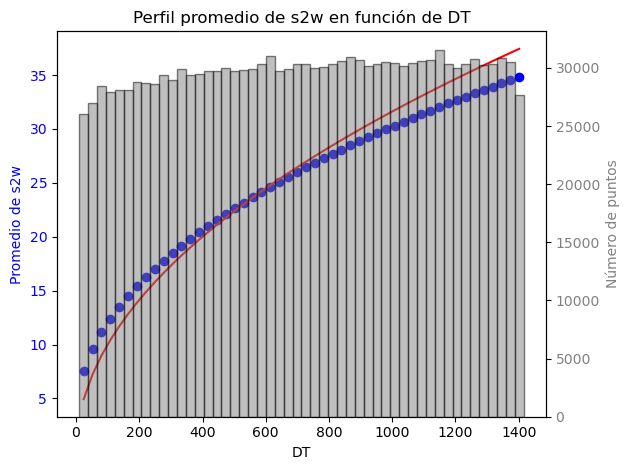

In [6]:
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
uncertainty = std_s2w / np.sqrt(count)

fig, ax1 = plt.subplots()

ax1.plot(bin_centers, mean_s2w, 'bo', label='Perfil con incertidumbre')
ax1.set_xlabel("DT")
ax1.set_ylabel("Promedio de s2w", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perfil promedio de s2w en función de DT")

ax2 = ax1.twinx()
ax2.bar(bin_centers, count, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, color='gray', label='Número de puntos', edgecolor='black')
ax2.set_ylabel("Número de puntos", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

ax1.plot(bin_centers,np.sqrt(bin_centers),color='red')
# Display legends and layout
fig.tight_layout()
plt.show()



Para este caso tiene sentido ya que es natural tener un señal más estrecha cerca del plano de detección, menos efectos de difusión o pérdidas debido a otros efectos. Por otro lado se ve que el promedio crece aproximadamente como $\sqrt N$ que es la curva dibujada en rojo

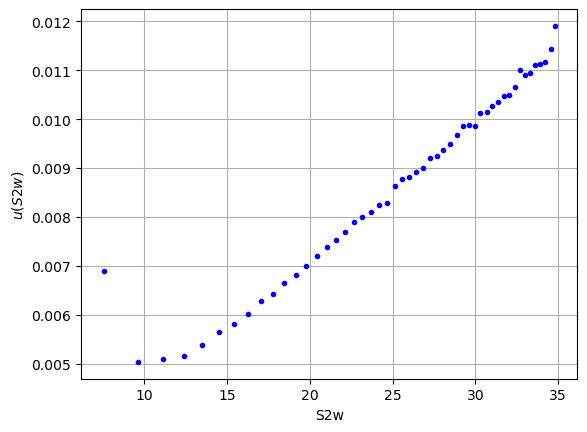

In [7]:
plt.plot(mean_s2w,uncertainty,'b.');plt.ylabel('$u(S2w)$');plt.xlabel('S2w');plt.grid(True)

In [8]:
#kdst[(kdst.DT > 60) & (kdst.DT < 100)][['S1w', 'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT']]

In [9]:
#kdst[kdst.DT > 1200][['S1w', 'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT']]

Veamos ahora S2h

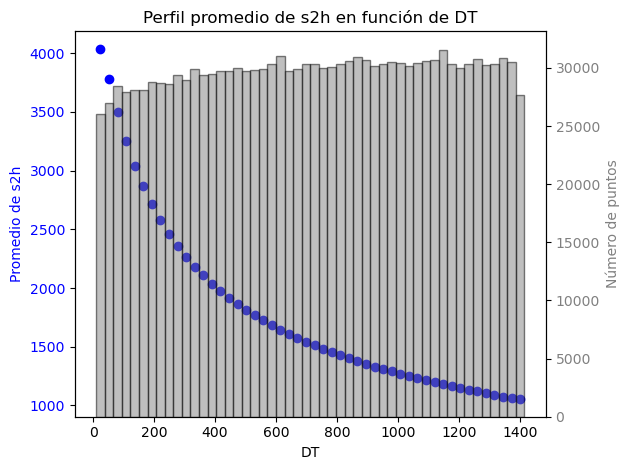

In [10]:
DT = kdst['DT']
s2h = np.array([s for s, d in zip(s2h, DT) if d > 10])
DT=np.array([i for i in DT if i> 10])

mean_s2h, bin_edges, _ = binned_statistic(DT, s2h, statistic='mean', bins=n_bins)
std_s2h, _, _ = binned_statistic(DT, s2h, statistic='std', bins=n_bins)
count, _, _ = binned_statistic(DT, s2h, statistic='count', bins=n_bins)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
uncertainty = std_s2h / np.sqrt(count)

fig, ax1 = plt.subplots()

ax1.plot(bin_centers, mean_s2h, 'bo', label='Perfil con incertidumbre')
ax1.set_xlabel("DT")
ax1.set_ylabel("Promedio de s2h", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perfil promedio de s2h en función de DT")

ax2 = ax1.twinx()
ax2.bar(bin_centers, count, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, color='gray', label='Número de puntos', edgecolor='black')
ax2.set_ylabel("Número de puntos", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

fig.tight_layout()
plt.show()


Tiene sentido esperarse un perfil de esta forma, ya que como dije antes, cerca del plano de detección habrá menos probabilidad de tener efectos difusivos importante y en el plano ($DT\approx 0$) la altura de la señal, y así su energía será máxima. En las 2 gráficas mostradas se ve como a bajos DT tenemos una señal más estrecha y con una altura mucho mayor, que la que tenemos a distancias mayores del plano. Esto hace que la integral de la señal sea mayor en el primer caso (la energía detectada, en pes, es en general mayor en los eventos situados cerca del plano de detección como esperábamos)

Vamos a ver ahora el perfil de S2e

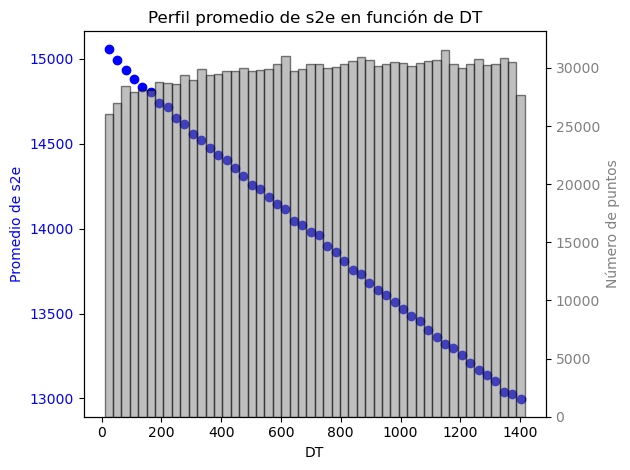

In [11]:
DT = kdst['DT']
s2e = np.array([s for s, d in zip(s2e, DT) if d > 10])
DT=np.array([i for i in DT if i> 10])

mean_s2e, bin_edges, _ = binned_statistic(DT, s2e, statistic='mean', bins=n_bins)
std_s2e, _, _ = binned_statistic(DT, s2e, statistic='std', bins=n_bins)
count, _, _ = binned_statistic(DT, s2e, statistic='count', bins=n_bins)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
uncertainty = std_s2e / np.sqrt(count)

fig, ax1 = plt.subplots()

ax1.plot(bin_centers, mean_s2e, 'bo', label='Perfil con incertidumbre')
ax1.set_xlabel("DT")
ax1.set_ylabel("Promedio de s2e", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perfil promedio de s2e en función de DT")

ax2 = ax1.twinx()
ax2.bar(bin_centers, count, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, color='gray', label='Número de puntos', edgecolor='black')
ax2.set_ylabel("Número de puntos", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

fig.tight_layout()
plt.show()


Vemos un perfil parecido al que veíamos el otros día. Un decaimiento exponencial fácilmente aproximable por una recta

Ahora para la carga que lleva la señal

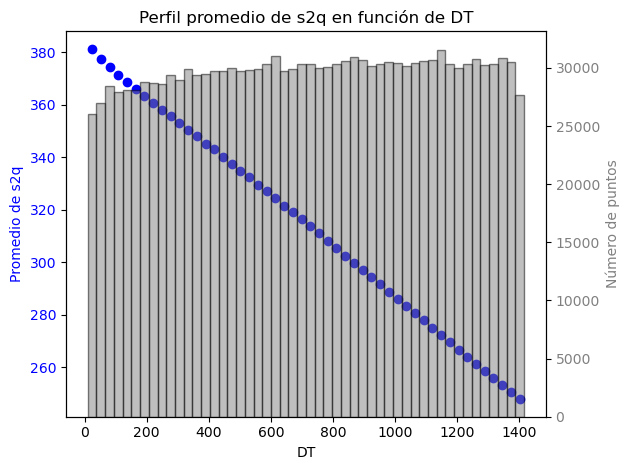

In [12]:
DT = kdst['DT']
s2q = np.array([s for s, d in zip(s2q, DT) if d > 10])
DT=np.array([i for i in DT if i> 10])

# Calcular la media y desviación estándar de DT en bins de s2w
mean_s2q, bin_edges, _ = binned_statistic(DT, s2q, statistic='mean', bins=n_bins)
std_s2q, _, _ = binned_statistic(DT, s2q, statistic='std', bins=n_bins)
count, _, _ = binned_statistic(DT, s2q, statistic='count', bins=n_bins)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
uncertainty = std_s2q / np.sqrt(count)

# Plotting
fig, ax1 = plt.subplots()

ax1.plot(bin_centers, mean_s2q, 'bo', label='Perfil con incertidumbre')
ax1.set_xlabel("DT")
ax1.set_ylabel("Promedio de s2q", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perfil promedio de s2q en función de DT")

# Create a second y-axis for the histogram (data count)
ax2 = ax1.twinx()
ax2.bar(bin_centers, count, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, color='gray', label='Número de puntos', edgecolor='black')
ax2.set_ylabel("Número de puntos", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Display legends and layout
fig.tight_layout()
plt.show()


En este caso se ve que la carga tambien cae con el DT linealmente (No veo que significa esto)

$\textbf{Veamos ahora la señal S1}$

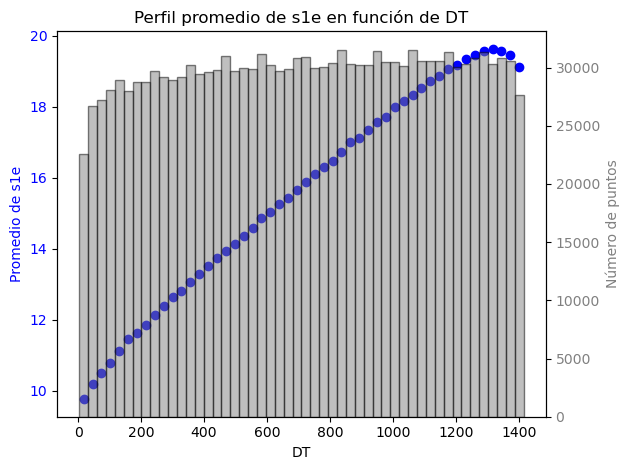

In [13]:
DT = kdst['DT']
s1e = np.array([s for s, d in zip(s1e, DT) if d > 0])
DT=np.array([i for i in DT if i> 0])

mean_s1e, bin_edges, _ = binned_statistic(DT, s1e, statistic='mean', bins=n_bins)
std_s1e, _, _ = binned_statistic(DT, s1e, statistic='std', bins=n_bins)
count, _, _ = binned_statistic(DT, s1e, statistic='count', bins=n_bins)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
uncertainty = std_s1e / np.sqrt(count)

fig, ax1 = plt.subplots()

ax1.plot(bin_centers, mean_s1e, 'bo', label='Perfil con incertidumbre')
ax1.set_xlabel("DT")
ax1.set_ylabel("Promedio de s1e", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perfil promedio de s1e en función de DT")

ax2 = ax1.twinx()
ax2.bar(bin_centers, count, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, color='gray', label='Número de puntos', edgecolor='black')
ax2.set_ylabel("Número de puntos", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

fig.tight_layout()
plt.show()

No entiendo este perfil de energías


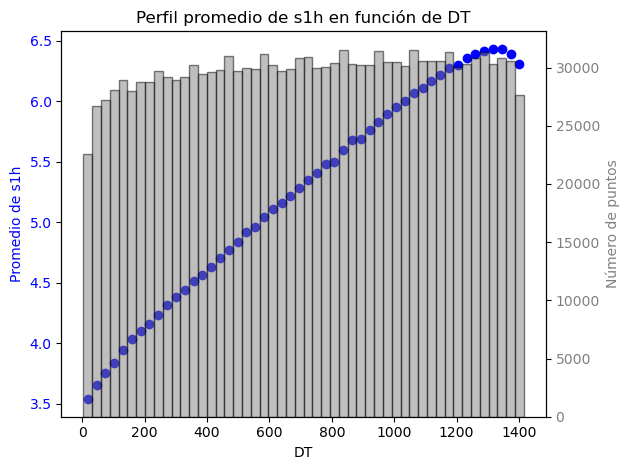

In [14]:
DT = kdst['DT']
s1h = np.array([s for s, d in zip(s1h, DT) if d > 00])
DT=np.array([i for i in DT if i> 0])

mean_s1h, bin_edges, _ = binned_statistic(DT, s1h, statistic='mean', bins=n_bins)
std_s1h, _, _ = binned_statistic(DT, s1h, statistic='std', bins=n_bins)
count, _, _ = binned_statistic(DT, s1h, statistic='count', bins=n_bins)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
uncertainty = std_s1h / np.sqrt(count)

fig, ax1 = plt.subplots()

ax1.plot(bin_centers, mean_s1h, 'bo', label='Perfil con incertidumbre')
ax1.set_xlabel("DT")
ax1.set_ylabel("Promedio de s1h", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perfil promedio de s1h en función de DT")

ax2 = ax1.twinx()
ax2.bar(bin_centers, count, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, color='gray', label='Número de puntos', edgecolor='black')
ax2.set_ylabel("Número de puntos", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

fig.tight_layout()
plt.show()

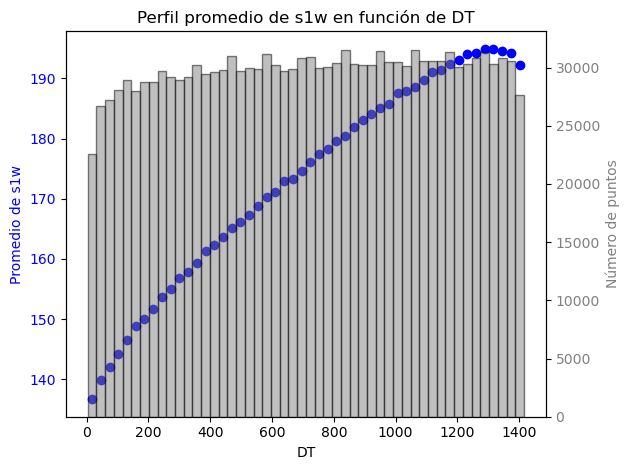

In [15]:
DT = kdst['DT']
s1w = np.array([s for s, d in zip(s1w, DT) if d > 00])
DT=np.array([i for i in DT if i> 0])

mean_s1w, bin_edges, _ = binned_statistic(DT, s1w, statistic='mean', bins=n_bins)
std_s1w, _, _ = binned_statistic(DT, s1w, statistic='std', bins=n_bins)
count, _, _ = binned_statistic(DT, s1w, statistic='count', bins=n_bins)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
uncertainty = std_s1w / np.sqrt(count)

fig, ax1 = plt.subplots()

ax1.plot(bin_centers, mean_s1w, 'bo', label='Perfil con incertidumbre')
ax1.set_xlabel("DT")
ax1.set_ylabel("Promedio de s1w", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perfil promedio de s1w en función de DT")

ax2 = ax1.twinx()
ax2.bar(bin_centers, count, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, color='gray', label='Número de puntos', edgecolor='black')
ax2.set_ylabel("Número de puntos", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

fig.tight_layout()
plt.show()

No entiendo por que evoluciona así S1


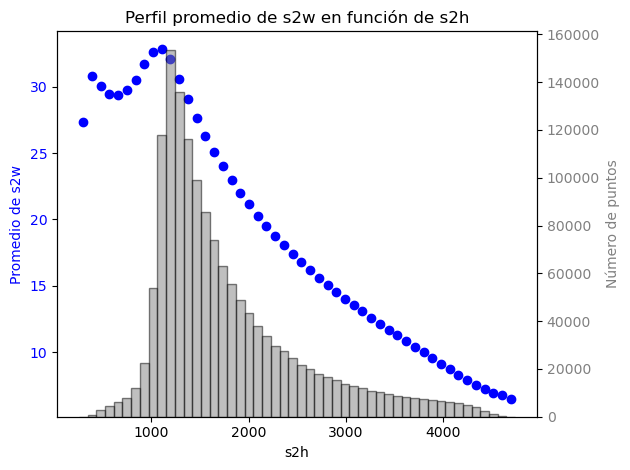

In [16]:
mean_s2hw, bin_edges, _ = binned_statistic(s2h, s2w, statistic='mean', bins=n_bins)
std_s2hw, _, _ = binned_statistic(s2h, s2w, statistic='std', bins=n_bins)
count, _, _ = binned_statistic(s2h, s2w, statistic='count', bins=n_bins)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
uncertainty = std_s2hw / np.sqrt(count)

fig, ax1 = plt.subplots()

ax1.plot(bin_centers, mean_s2hw, 'bo', label='Perfil con incertidumbre')
ax1.set_xlabel("s2h")
ax1.set_ylabel("Promedio de s2w", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perfil promedio de s2w en función de s2h")

ax2 = ax1.twinx()
ax2.bar(bin_centers, count, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, color='gray', label='Número de puntos', edgecolor='black')
ax2.set_ylabel("Número de puntos", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

fig.tight_layout()
plt.show()

Tiene sentido, tendremos un número menor de eventos con una altura muy alta y se debería corresponder a eventos de más energía, son eventos que ocurren más cerca del plano de energías. En los eventos con más altura de s2 hay menos fenómenos de difusión y entonces decrece la anchura de la señal

In [17]:
len(s2e)==len(s2w)

True

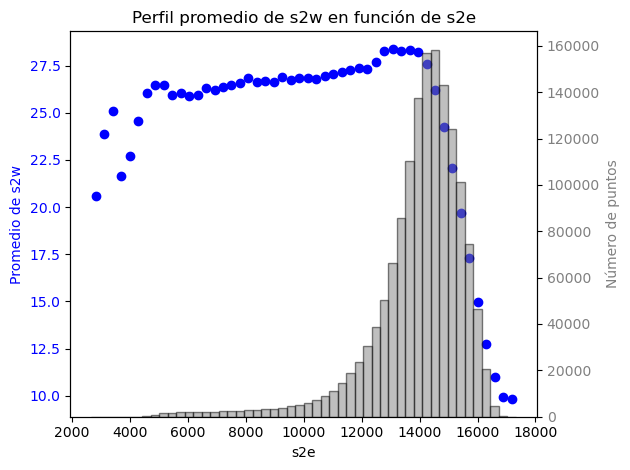

In [18]:
mean_s2we, bin_edges, _ = binned_statistic(s2e, s2w, statistic='mean', bins=n_bins)
std_s2we, _, _ = binned_statistic(s2e, s2w, statistic='std', bins=n_bins)
count, _, _ = binned_statistic(s2e, s2w, statistic='count', bins=n_bins)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
uncertainty = std_s2we / np.sqrt(count+0.0000001)

fig, ax1 = plt.subplots()

ax1.plot(bin_centers, mean_s2we, 'bo', label='Perfil con incertidumbre')
ax1.set_xlabel("s2e")
ax1.set_ylabel("Promedio de s2w", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perfil promedio de s2w en función de s2e")

ax2 = ax1.twinx()
ax2.bar(bin_centers, count, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, color='gray', label='Número de puntos', edgecolor='black')
ax2.set_ylabel("Número de puntos", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

fig.tight_layout()
plt.show()

Un poco la misma idea que antes

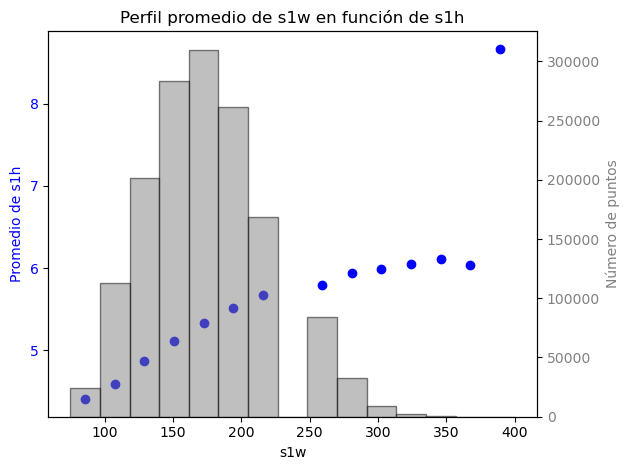

In [19]:
s1w = kdst['S1w']
s1h = kdst['S1h']
s1e = kdst['S1e']

mean_s1hw, bin_edges, _ = binned_statistic(s1w, s1h, statistic='mean', bins=15)
std_s1hw, _, _ = binned_statistic(s1w, s1h, statistic='std', bins=15)
count, _, _ = binned_statistic(s1w, s1h, statistic='count', bins=15)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
uncertainty = std_s1hw / np.sqrt(count)

fig, ax1 = plt.subplots()

ax1.plot(bin_centers, mean_s1hw, 'bo', label='Perfil con incertidumbre')
ax1.set_xlabel("s1w")
ax1.set_ylabel("Promedio de s1h", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perfil promedio de s1w en función de s1h")

ax2 = ax1.twinx()
ax2.bar(bin_centers, count, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, color='gray', label='Número de puntos', edgecolor='black')
ax2.set_ylabel("Número de puntos", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

fig.tight_layout()
plt.show()

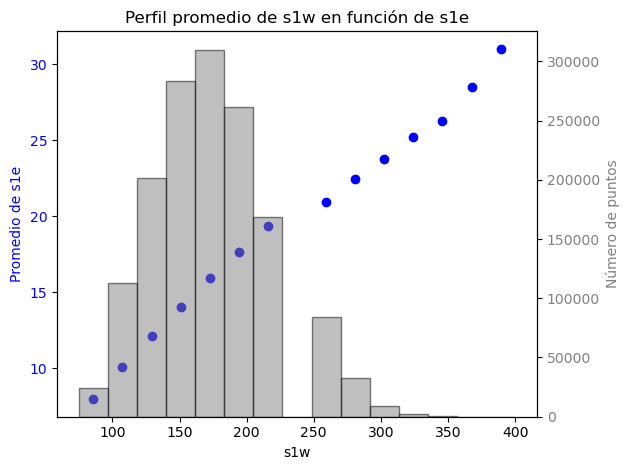

In [20]:
mean_s1we, bin_edges, _ = binned_statistic(s1w, s1e, statistic='mean', bins=15)
std_s1we, _, _ = binned_statistic(s1w, s1e, statistic='std', bins=15)
count, _, _ = binned_statistic(s1w, s1e, statistic='count', bins=15)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
uncertainty = std_s1we / np.sqrt(count+0.0000001)

fig, ax1 = plt.subplots()

ax1.plot(bin_centers, mean_s1we, 'bo', label='Perfil con incertidumbre')
ax1.set_xlabel("s1w")
ax1.set_ylabel("Promedio de s1e", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perfil promedio de s1w en función de s1e")

ax2 = ax1.twinx()
ax2.bar(bin_centers, count, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, color='gray', label='Número de puntos', edgecolor='black')
ax2.set_ylabel("Número de puntos", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

fig.tight_layout()
plt.show()

### Energía en plano XY bineado

In [21]:
energías_eventos_corte=[]
DT_corte=[]
X_corte=[]
Y_corte=[]


for i in range(len(kdst['S2e'])):
    if 715>kdst['DT'][i] and 685<kdst['DT'][i]:
        energías_eventos_corte.append(kdst['S2e'][i])
        X_corte.append(kdst['X'][i])
        Y_corte.append(kdst['Y'][i])
        DT_corte.append(kdst['DT'][i])
        
print('El porcentaje de eventos dentro de este corte es',np.round(len(energías_eventos_corte)/len(kdst['S2e'])*100,3),'%')

El porcentaje de eventos dentro de este corte es 2.182 %


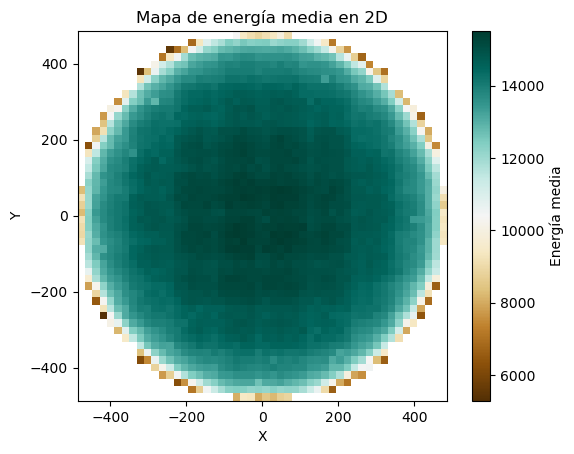

In [22]:
mean_E, x_edges,y_edges,binned = binned_statistic_2d(X_corte, Y_corte, energías_eventos_corte, statistic='mean', bins=50)
X, Y = np.meshgrid(x_edges, y_edges)

fig, ax = plt.subplots()  # Crea los subplots correctamente
c = ax.pcolormesh(X, Y, mean_E.T, cmap='BrBG')
plt.colorbar(c, label='Energía media')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Mapa de energía media en 2D')
ax.set_aspect('equal')  # Asigna el aspecto de manera correcta

plt.show()

### Ajustes Repetidos.

Para empezar hago el mismo filtro que en el notebook anterior para quedarme solo con eventos que tienen lugar en un cilindro estrecho centrado en el origen del plano XY  

In [23]:
energías_eventos_centrales=[]
posicion_axial=[]

energías_eventos_externos=[]
posicion_externa=[]

for i in range(len(kdst['S2e'])):
    if kdst['R'][i]<=np.sqrt(2*75**2):
        energías_eventos_centrales.append(kdst['S2e'][i])
        posicion_axial.append(kdst['DT'][i])
    else:
        energías_eventos_externos.append(kdst['S2e'][i])
        posicion_externa.append(kdst['DT'][i])
        
print('El porcentaje de eventos en un radio menor de 80mm es',np.round(len(posicion_axial)/len(kdst['DT'])*100,3),'%')
print('El porcentaje de eventos en un radio mayor de 80mm es',np.round(len(posicion_externa)/len(kdst['DT'])*100,3),'%')


El porcentaje de eventos en un radio menor de 80mm es 4.853 %
El porcentaje de eventos en un radio mayor de 80mm es 95.147 %


Separo los eventos en grupos que contienen datos de 100 eventos

In [24]:
series_de_datos_separadas_energías = [energías_eventos_centrales[100*i:100*i+100] for i in range(len(energías_eventos_centrales))]
series_de_datos_separadas_posiciones = [posicion_axial[100*i:100*i+100] for i in range(len(posicion_axial))]

Ajusto cada uno de las series y almaceno la media de $\tau$, la $E_0$ y sus incertidumbres.

In [25]:
def atenuacion_exponencial(x,mu,E0):
    return E0*np.exp(-x/mu)

media_tau=[]
media_E0=[]

incertidumbre_tau=[]
incertidumbre_E0=[]

for i in range(int(len(series_de_datos_separadas_energías)/100)):
    popt,pcov=curve_fit(atenuacion_exponencial,series_de_datos_separadas_posiciones[i],series_de_datos_separadas_energías[i],p0=[10000,1600])
    if popt[0]<13000 and popt[0]>1600:
        media_tau.append(popt[0]);media_E0.append(popt[1])
        incertidumbre_tau.append(np.sqrt(pcov[0][0]));incertidumbre_E0.append(np.sqrt(pcov[1][1]))

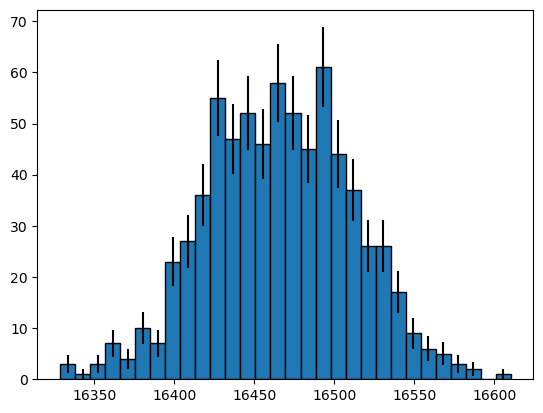

In [26]:
counts, bin_edges, _ = binned_statistic(media_E0, media_E0, statistic='count', bins=30)
errors = np.sqrt(counts)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.bar(bin_centers, counts, width=np.diff(bin_edges), edgecolor='black')

plt.errorbar(bin_centers, counts, yerr=errors, fmt='none', color='black')
plt.show()

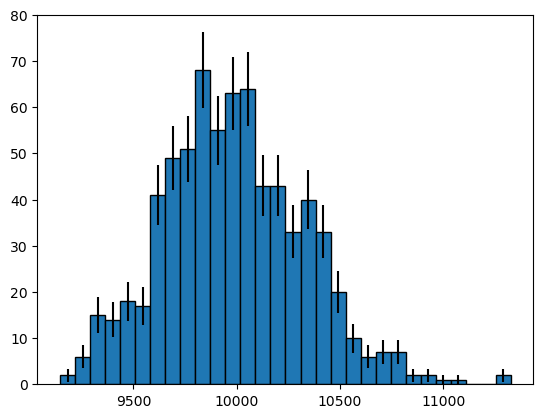

In [27]:
counts, bin_edges, _ = binned_statistic(media_tau, media_tau, statistic='count', bins=30)
errors = np.sqrt(counts)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.bar(bin_centers, counts, width=np.diff(bin_edges), edgecolor='black')
plt.errorbar(bin_centers, counts, yerr=errors, fmt='none', color='black')
plt.show()

Siguen una distribución gaussiana, como queríamos ver